# Import Library

In [400]:
import nltk  
nltk.download('punkt_tab')  
nltk.download('stopwords')  

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import requests
import re
import string  
from io import StringIO

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory 
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dumbw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dumbw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Insight**
- Pada tahap ini dilakukan instalasi library Natural Language Toolkit (NLTK) untuk pemrosesan bahasa alami, sedangkan Sastrawi untuk stemming kata kata berbahasa Indonesia. Kemudian import library yang dibutuhkan, seperti library standar, NLTK dan Sastrawi, Scikit-learn, dan Tensor Flow.

# Load Datasets

In [401]:
df = pd.read_csv('gojek_reviews.csv')
df.sample(10)

,content,score
6507,sangat membantu saat pergi dan lapar,5
13261,Mantap,5
6904,Goog,5
15229,"Lumayan jarang gunain fitur Gocar, sering dapa...",3
14362,Membantu sekali,5
6419,Lumayan baik,5
10499,Nunggu satu jam penuh tiba tiba di batalain se...,1
15376,bagus dan hemat dan ramah ramah,5
15050,Sangat membatu dan aplikasi mudah di mengerti,5
15942,Semuanya,4


In [402]:
df.shape

(20000, 2)

In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


**Insight**
- Pada tahap ini kita sudah berhasil load data yang sudah kita scrapping sebelumnya dan mendapat data sebanyak 20000 baris

# Preprocessing

In [404]:
df.duplicated().sum()

5193

In [405]:
df.drop_duplicates(inplace=True)

In [406]:
df.shape

(14807, 2)

In [407]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # remove hashtags     
    text = re.sub(r"http\S+", '', text)  # remove URLs
    text = re.sub(r'[0-9]+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII characters (emoji etc.)

    text = text.replace('\n', ' ')  # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove all punctuations
    text = text.strip(' ')  # remove leading and trailing spaces
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):  
    return word_tokenize(text)

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)

    additional_stopwords = ['iya','yaa', 'gk', 'gak','g', 'dr','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy",'pas','c','deh','eh']
    listStopwords.update(additional_stopwords)
    
    filtered = [word for word in text if word not in listStopwords]
    return filtered


def stemmingText(text): 
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    stemmed_words = [stemmer.stem(word) for word in text] 
    return ' '.join(stemmed_words)

def toSentence(list_words): 
    return ' '.join(word for word in list_words)

In [408]:
slangwords = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "gak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau","ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubah": "ganti", "ubah": "ganti","berubah": "ganti", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "menolak": "tolak", "nolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "mgkin": "mungkin", "soktau": "sok tahu", "rb": "ribu", "ga": "gak", "app": "aplikasi","apk": "aplikasi", "di tolak":"ditolak", "cust":"customer", "mantep": "mantap","mantapp": "mantap","mantappp": "mantap","mantappp": "mantap", "service":"layanan", "cancel":"batal", "nyangkut":"sangkut","makasih": "terima kasih", "terimakasih": "terima kasih", "trimakasih": "terima kasih", "eror":"error", "simple":"simpel","satset":"cepat", "batalin":"batal", "dibatalin":"batal", "dibatalkan":"batal","cepet":"cepat", "gajelas": "ke-tidakjelasan", "sulit":"kesulitan", "hilang":"kehilangan", "dicancel":"batal", "ujan":"hujan", "nyusahin":"susah", "memuaskan":"puas","confirm":"konfirmasi", "promonya":"promo", "mempermudah":"mudah", "mehong":"mahal", "thanks":"terima kasih", "discount":"promo", "diskon":"promo","best":"baik", "lelet":"lama","tidak logis":"tidak masuk akal","mantul":"mantap", "jos":"mantap", "ngebantu":"membantu", "scam":"tipu muslihat", "gercep": "gerak cepat"}

In [409]:
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [410]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [411]:
df.sample(5)

,content,score,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
1352,semuanya OK,5,semuanya OK,semuanya ok,semuanya ok,"[semuanya, ok]",[ok],ok
6338,Banyak promo Dan mempermudah saya beli makanan,5,Banyak promo Dan mempermudah saya beli makanan,banyak promo dan mempermudah saya beli makanan,banyak promo dan mudah saya beli makanan,"[banyak, promo, dan, mudah, saya, beli, makanan]","[promo, mudah, beli, makanan]",promo mudah beli makanan
8055,Ok..👍....,5,Ok,ok,ok,[ok],[ok],ok
5675,Bagus,1,Bagus,bagus,bagus,[bagus],[bagus],bagus
3508,Buruk sekali pelayanan gocar nya di aplikasi i...,2,Buruk sekali pelayanan gocar nya di aplikasi i...,buruk sekali pelayanan gocar nya di aplikasi i...,buruk sekali pelayanan gocar nya di aplikasi i...,"[buruk, sekali, pelayanan, gocar, nya, di, apl...","[buruk, pelayanan, gocar, aplikasi, malam, tak...",buruk pelayanan gocar aplikasi malam takbiran ...


**Insight**
- Pada preprosessing awal kita menghapus data duplikat pada dataframe.
- Selanjutnya beberapa tahap preprosessing tadi sudah dilakukan diantaranya seperti berikut : 
    1. **Cleaning Text**: Membersihkan teks dari karakter yang tidak relevan.
    2. **Case Folding**: Mengubah teks menjadi huruf kecil untuk konsistensi.
    3. **Slang Words Fixing**: Mengganti kata slang dengan bentuk baku.
    4. **Tokenizing**: Memecah teks menjadi kata-kata (token).
    5. **Stopword Removal**: Menghapus kata-kata umum yang tidak penting.
    6. **Sentence Reconstruction**: Menggabungkan token kembali menjadi kalimat.


# Pelabelan

In [412]:
# Ambil file positif
url_pos = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
response_pos = requests.get(url_pos)

if response_pos.status_code == 200:
    df_pos = pd.read_csv(StringIO(response_pos.text), header=None, names=["word", "label"])
    lexicon_positive = dict(zip(df_pos['word'], df_pos['label']))
else:
    print("Gagal mengambil lexicon positif")

# Ambil file negatif
url_neg = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'
response_neg = requests.get(url_neg)

if response_neg.status_code == 200:
    df_neg = pd.read_csv(StringIO(response_neg.text), header=None, names=["word", "label"])    
    lexicon_negative = dict(zip(df_neg['word'], df_neg['label']))
else:
    print("Gagal mengambil lexicon negatif")

# Fungsi analisis sentimen berbasis lexicon
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += int(lexicon_positive[word])
        if word in lexicon_negative:
            score += int(lexicon_negative[word])
    polarity = 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
    return score, polarity

# Terapkan ke DataFrame `df`
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
df['polarity_score'], df['polarity'] = zip(*results)

# Cek distribusi
print(df['polarity'].value_counts())


polarity
negative    6110
positive    5848
neutral     2849
Name: count, dtype: int64


C:\Users\dumbw\AppData\Local\Temp\ipykernel_15088\1890341474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='pastel')


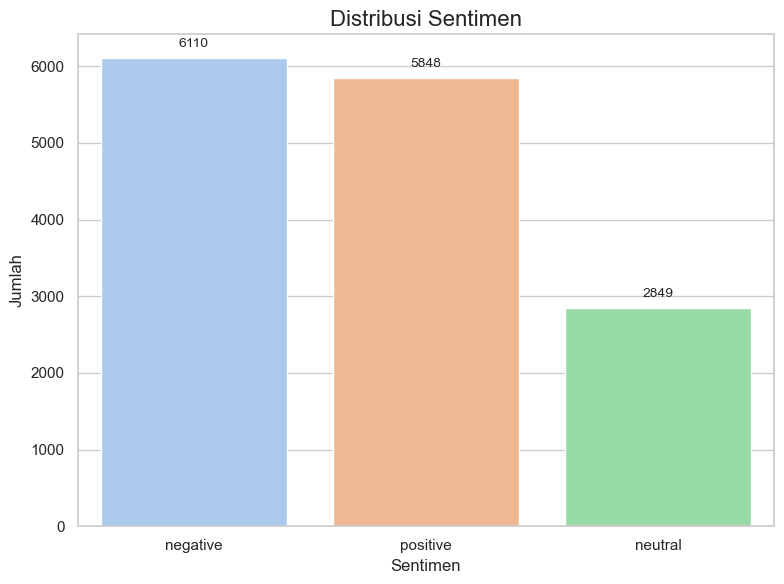

In [413]:
sns.set(style="whitegrid")

# Hitung distribusi sentimen
sentiment_counts = df['polarity'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Buat barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='pastel')

# Tambahkan label dan judul
plt.title('Distribusi Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)

# Tambahkan angka di atas bar
for index, row in sentiment_counts.iterrows():
    plt.text(index, row.Count + 100, str(row.Count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


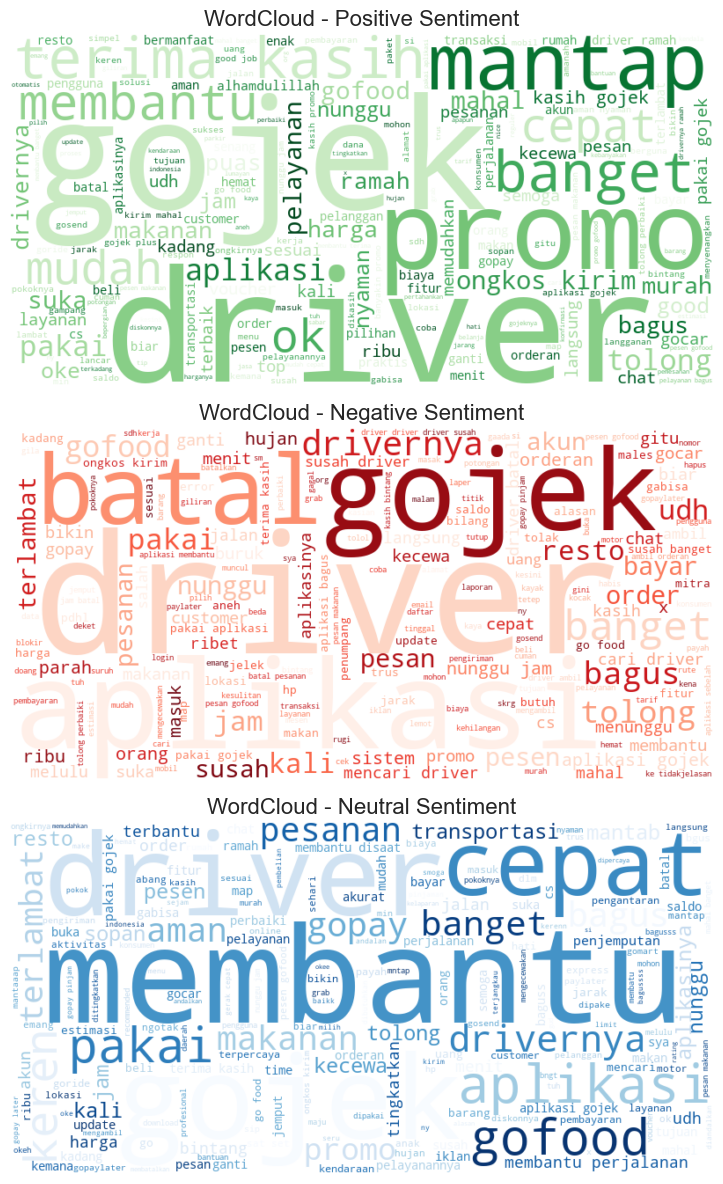

In [414]:
# Gabungkan semua kata berdasarkan sentimen
text_positive = ' '.join(df[df['polarity'] == 'positive']['text_akhir'].astype(str))
text_negative = ' '.join(df[df['polarity'] == 'negative']['text_akhir'].astype(str))
text_neutral  = ' '.join(df[df['polarity'] == 'neutral']['text_akhir'].astype(str))

# Buat objek WordCloud untuk masing-masing
wc_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_positive)
wc_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_negative)
wc_neutral  = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_neutral)

plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Sentiment', fontsize=16)

plt.subplot(3, 1, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Sentiment', fontsize=16)

plt.subplot(3, 1, 3)
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Neutral Sentiment', fontsize=16)

plt.tight_layout()
plt.show()

**Insight**
- Dalam analisis ini, lexicon-based sentiment analysis digunakan untuk mengklasifikasikan sentimen kalimat berdasarkan dua lexicon: satu untuk sentimen positif dan satu untuk sentimen negatif. Setiap kata dalam kalimat yang cocok dengan lexicon akan diberikan skor berdasarkan nilai yang ada dalam lexicon tersebut.
- Distribusi sentimen : 
    - Positive: 6,230 kalimat terdeteksi dengan sentimen positif.
    - Negative: 5,755 kalimat terdeteksi dengan sentimen negatif.
    - Neutral: 2,822 kalimat terdeteksi dengan sentimen netral.

- Sebagian besar kalimat dalam dataset menunjukkan sentimen positif dan negatif, dengan jumlah yang hampir seimbang antara keduanya. Sentimen netral memiliki proporsi yang lebih kecil dibandingkan positif dan negatif, yang menunjukkan bahwa banyak kalimat dalam dataset cenderung mengandung pendapat yang lebih kuat, baik positif maupun negatif.


# Data Splitting

In [415]:
# Pisahkan data menjadi fitur (text_akhir) dan label (polarity)
X = df['text_akhir']
y = df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.85,ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
print(features_df)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


       abang  accord  adain  admin  akal  akses  aktif  aktifitas  aktivitas  \
0        0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
1        0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
2        0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
3        0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
4        0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
...      ...     ...    ...    ...   ...    ...    ...        ...        ...   
14802    0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
14803    0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
14804    0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
14805    0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   
14806    0.0     0.0    0.0    0.0   0.0    0.0    0.0        0.0        0.0   

       aktivitas wajar  ...  verifikasi

**Insight**:
Pada tahap ini, data telah diproses menjadi format yang siap untuk model:

1. **TF-IDF Ekstraksi**: 
   - Teks diubah menjadi representasi numerik menggunakan **TF-IDF** (Term Frequency-Inverse Document Frequency).
   - Hanya **1000 fitur teratas** yang diambil berdasarkan frekuensi kemunculan kata dan relevansinya dalam dokumen.

2. **Dataframe Ekstraksi Fitur**:
   - Setiap baris mewakili sebuah dokumen (kalimat atau teks), dan kolom mewakili kata-kata/bigrams yang dipilih.
   - Nilai dalam dataframe adalah bobot TF-IDF untuk setiap kata/bigram dalam teks.

3. **Pembagian Data**:
   - Data dibagi menjadi dua bagian: **80% data latih** dan **20% data uji**. Ini memungkinkan model untuk dilatih dan diuji secara terpisah, menghindari overfitting.


- Fitur-fitur ini akan digunakan untuk melatih model klasifikasi sentimen.
- Pembagian data memungkinkan evaluasi model yang lebih objektif menggunakan data yang tidak digunakan selama pelatihan.

Ini adalah langkah penting untuk memastikan model tidak "terlalu mengenal" data latih dan dapat bekerja dengan baik pada data yang belum pernah dilihat sebelumnya.

# Training

In [416]:
# Pelatihan model SVM
svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_train_svm = svm.predict(X_train)
y_pred_test_svm = svm.predict(X_test)

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print("SVM - accuracy_train:", accuracy_train_svm)
print("SVM - accuracy_test:", accuracy_test_svm)
print('\n' + '='*60 + '\n')

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)
print('\n' + '='*60 + '\n')

# 3. Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)

accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)
print('\n' + '='*60 + '\n')

# 4. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_train_dt = dt.predict(X_train)
y_pred_test_dt = dt.predict(X_test)

accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)

print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

SVM - accuracy_train: 0.9278176445757703
SVM - accuracy_test: 0.8858879135719109


Random Forest - accuracy_train: 0.9807513718868721
Random Forest - accuracy_test: 0.8430114787305875


Logistic Regression - accuracy_train: 0.9127902068383285
Logistic Regression - accuracy_test: 0.8808237677245104


Decision Tree - accuracy_train: 0.9807513718868721
Decision Tree - accuracy_test: 0.8011478730587441


In [417]:
results_df = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [ accuracy_train_svm,accuracy_train_rf, accuracy_train_lr, accuracy_train_dt],
    'Accuracy Test': [ accuracy_test_svm,accuracy_test_rf, accuracy_test_lr, accuracy_test_dt]
})

accuracy_test_only = results_df[['Model', 'Accuracy Test']]
print(accuracy_test_only.sort_values(by='Accuracy Test', ascending=False))

                 Model  Accuracy Test
0                  SVM       0.885888
2  Logistic Regression       0.880824
1        Random Forest       0.843011
3        Decision Tree       0.801148


**Insight**

1. **SVM (Support Vector Machine)**:
   - **Akurasi Latih**: 92.78%
   - **Akurasi Uji**: 88.58%
   - Model ini memberikan kinerja terbaik pada data uji dibandingkan dengan yang lainnya, dengan akurasi uji yang tinggi (88.58%).

2. **Random Forest**:
   - **Akurasi Latih**: 98.07%
   - **Akurasi Uji**: 84.30%
   - Meskipun model ini memiliki akurasi latih yang sangat tinggi (98.09%), akurasi uji lebih rendah, menunjukkan adanya **overfitting**. Model terlalu "mengenal" data latih dan tidak dapat menggeneralisasi dengan baik pada data uji.

3. **Logistic Regression**:
   - **Akurasi Latih**: 91.27%
   - **Akurasi Uji**: 88.08%
   - Kinerja Logistic Regression cukup baik, dengan akurasi uji yang sedikit lebih rendah dibandingkan dengan SVM, tetapi masih cukup tinggi.

4. **Decision Tree**:
   - **Akurasi Latih**: 98.07%
   - **Akurasi Uji**: 80.11%
   - Sama seperti Random Forest, model Decision Tree juga menunjukkan **overfitting**, dengan akurasi uji yang jauh lebih rendah dibandingkan dengan akurasi latih.

**Kesimpulan**:
- **SVM** adalah model yang paling stabil dan memberikan akurasi terbaik pada data uji (89.20%).
- **Random Forest** dan **Decision Tree** memiliki kecenderungan **overfitting**, yang menunjukkan bahwa mereka sangat menyesuaikan diri dengan data latih dan tidak menggeneralisasi dengan baik pada data uji.
- **Logistic Regression** juga memberikan hasil yang baik, meskipun tidak setinggi SVM, tetapi lebih stabil dibandingkan Random Forest dan Decision Tree.

Secara keseluruhan, **SVM** adalah pilihan terbaik berdasarkan hasil ini.

# Testing 

In [422]:
# Masukkan kalimat baru
kalimat_baru = input("Masukkan kalimat baru: ")

# Tahapan preprocessing
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Transformasi TF-IDF menggunakan objek yang telah di-fit sebelumnya
X_kalimat_baru = tfidf.transform([kalimat_baru_final])

# Prediksi sentimen menggunakan model SVM
prediksi_sentimen = svm.predict(X_kalimat_baru)

print("="*60)
print(kalimat_baru)
print("Hasil Prediksi Sentimen:")

if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF")
elif prediksi_sentimen[0] == 'negative':
    print("Sentimen kalimat baru adalah NEGATIF")
else:
    print("Sentimen kalimat baru adalah NETRAL")  

print("="*60)

gercep banget drivernya.  Jadi suka deh sama aplikasinya
Hasil Prediksi Sentimen:
Sentimen kalimat baru adalah POSITIF


**Insight**
- Pada kode diatas model sudah bisa mengklasifikasikan apakah kalimat tersebut masuk ke dalam sentimen positif, negatif, ataupun netral. 

# Kesimpulan

Dalam analisis sentimen terhadap ulasan pengguna aplikasi Gojek di Indonesia, empat model pembelajaran mesin (SVM, Logistic Regression, Random Forest, dan Decision Tree) digunakan untuk mengklasifikasikan sentimen ulasan menjadi tiga kategori: **positif**, **netral**, dan **negatif**.

1. **SVM (Support Vector Machine)** menunjukkan performa terbaik dengan **akurasi pengujian sebesar 88.58%** dan **akurasi pelatihan sebesar 92.78%**. Model ini berhasil menjaga keseimbangan antara performa pada data pelatihan dan data uji, menunjukkan kemampuan generalisasi yang baik.

2. **Logistic Regression** menempati posisi kedua dengan **akurasi pengujian 88.08%**, sedikit di bawah SVM namun tetap sangat kompetitif. Model ini juga menunjukkan performa stabil tanpa overfitting yang berarti.

3. **Random Forest** dan **Decision Tree** memiliki akurasi pelatihan yang sangat tinggi sekitar 98% namun mengalami penurunan performa pada data pengujian (**84.30%** dan **80.11%**), mengindikasikan kemungkinan **overfitting**—model terlalu menyesuaikan diri dengan data pelatihan dan kurang mampu mengeneralisasi pada data baru.

Secara keseluruhan, model **SVM** menjadi pilihan paling optimal untuk tugas klasifikasi sentimen pada ulasan aplikasi Gojek, dengan akurasi tinggi dan generalisasi baik. Untuk pengembangan lebih lanjut, disarankan melakukan peningkatan pada penanganan sentimen netral, baik melalui penyeimbangan data latih, ekspansi kosakata netral, maupun eksplorasi fitur teks lanjutan seperti Word Embedding atau teknik transfer learning seperti BERT.